In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
import sys
sys.path.append('../')
from Draw_fig import Draw_plot
from standardization_process import *

# Summary for the raw data

In [5]:
chembl = pd.read_csv('../data/data_mining_results/water_solubility/chembl_solubility_data_mining.csv')
esol = pd.read_csv('../data/raw_data/solubility/delaney 2004.txt')
cuietal = pd.read_excel('../data/raw_data/solubility/9,943 compounds_0.xlsx')
ons = pd.read_csv('../data/raw_data/solubility/water_solubility_data.csv')
wangetal1 = pd.read_excel('../data/raw_data/solubility/Wangetal/ci800406y_si_001.xlsx')
wangetal2 = pd.read_excel('../data/raw_data/solubility/Wangetal/Jain and Yalkowsky.xls')
wangetal3 = pd.read_excel('../data/raw_data/solubility/Wangetal/Beilstein.xlsx')
wangetal4 = pd.read_excel('../data/raw_data/solubility/Wangetal/goodman_25celsius.xlsx')
wangetal5 = pd.read_excel('../data/raw_data/solubility/Wangetal/wang_collected.xlsx')

In [6]:
wangetal = pd.concat([wangetal1, wangetal2, wangetal3, wangetal4, wangetal5], ignore_index=True)
wangetal.shape

(3705, 9)

In [8]:
pd.concat([esol,cuietal,ons,wangetal]).shape

(15692, 27)

In [15]:
chembl = chembl[~chembl['Water Solubility'].isna()]
chembl['Assay ChEMBL ID'].nunique()

1849

In [16]:
chembl.shape

(17141, 22)

# Load data

## Chembl

In [20]:
chembl = pd.read_csv('../data/data_mining_results/water_solubility/chembl_solubility_data_mining.csv')

In [21]:
chembl.shape, chembl.columns

((52947, 22),
 Index(['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation',
        'Standard Value', 'Standard Units', 'Assay ChEMBL ID',
        'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label',
        'Document ChEMBL ID', 'Source Description', 'Document Journal',
        'Document Year', 'pH Level', 'Solvent/System Composition',
        'Time Period', 'Measurement Technique', 'Temperature Range',
        'water_solubility', 'Water Solubility'],
       dtype='object'))

In [22]:
chembl.head(3)

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Document ChEMBL ID,Source Description,Document Journal,Document Year,pH Level,Solvent/System Composition,Time Period,Measurement Technique,Temperature Range,water_solubility,Water Solubility
0,CHEMBL381394,CCCC[C@H](NC(=O)O[C@@H]1C(=O)N(C(=O)Nc2c(C)noc...,Solubility,'=',320.0,ug.mL-1,CHEMBL860622,Solubility in fasted state-simulated intestina...,P,BAO_0000100,small-molecule physicochemical format,CHEMBL1146061,Scientific Literature,Bioorg Med Chem Lett,2006.0,6.8,fasted state-simulated intestinal fluid,NaN,NaN,NaN,True,NaN
1,CHEMBL383687,CCCC[C@H](NC(=O)O[C@@H]1C(=O)N(C(=O)c2ccno2)CC...,Solubility,'=',68.0,ug.mL-1,CHEMBL860622,Solubility in fasted state-simulated intestina...,P,BAO_0000100,small-molecule physicochemical format,CHEMBL1146061,Scientific Literature,Bioorg Med Chem Lett,2006.0,6.8,fasted state-simulated intestinal fluid,NaN,NaN,NaN,True,NaN
2,CHEMBL203501,CCCC[C@@H](/C=N/NS(=O)(=O)N(C)C)NC(=O)OC(C)(C)C,Solubility,'=',380.0,ug.mL-1,CHEMBL868304,Solubility in fasted state-simulated intestina...,P,BAO_0000100,small-molecule physicochemical format,CHEMBL1138109,Scientific Literature,Bioorg Med Chem Lett,2006.0,6.8,fasted state-simulated intestinal fluid,NaN,NaN,NaN,True,NaN


### check experimental data

In [23]:
chembl = chembl[chembl['Standard Relation'] == "'='"]

In [24]:
chembl['water_solubility'] = chembl['water_solubility'].fillna(False)
chembl['Water Solubility'] = chembl['Water Solubility'].fillna(False)

chembl['water_solubility'].value_counts(), chembl['Water Solubility'].value_counts()

(False    21740
 True     16623
 Name: water_solubility, dtype: int64,
 False    27941
 True     10422
 Name: Water Solubility, dtype: int64)

In [25]:
chembl = chembl[chembl['water_solubility']|chembl['Water Solubility']]
chembl.shape

(27045, 22)

In [26]:
chembl['Standard Units'].value_counts(dropna=False)

nM         14789
ug.mL-1    12256
Name: Standard Units, dtype: int64

In [27]:
chembl = process_stage_1(chembl,'Smiles')

100%|███████████████████████████████████████| 27045/27045 [00:03<00:00, 8676.95it/s]


SANITIZE_NONE    27045
Name: Smiles_check, dtype: int64


100%|████████████████████████████████████| 27045/27045 [00:00<00:00, 1093696.81it/s]
27045it [00:30, 898.37it/s] 


Metal in Smiles amount: 0


100%|██████████████████████████████████████| 27045/27045 [00:02<00:00, 10050.83it/s]


In [28]:
chembl['MW'] = chembl['Smiles_unify'].apply(lambda x: Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))

In [29]:
def standardlised_value(x):
    value = float(x['Standard Value'])
    unit = x['Standard Units']
    mw = x['MW']
    
    if unit == 'nM':
        return value
    elif unit == 'ug.mL-1':
        return value/mw*1000000
    elif unit == 'log(mol/L)':
        return 10**value*1000000000
    else:
        print(unit)

In [30]:
chembl['value_nM'] = chembl.apply(standardlised_value,axis=1)
chembl = chembl[chembl['value_nM'] > 0]

In [31]:
chembl['value_nM_log'] = chembl['value_nM'].apply(lambda x: round(np.log10(x), 4))

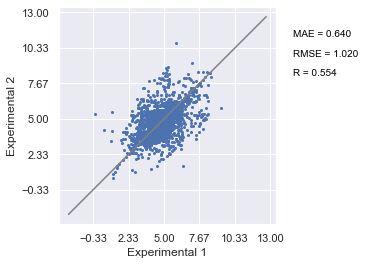

In [32]:
plot_diagram(chembl,['Smiles_unify'],'value_nM_log')

In [33]:
for experiment in ['pH Level', 'Solvent/System Composition',
        'Time Period', 'Measurement Technique', 'Temperature Range']:
    display(chembl[experiment].value_counts(dropna=False))

7.4            9543
NaN            9344
6.5            1905
6.8            1713
7.0            1659
2.0             923
4.0             296
1.2             265
7.2             201
1.0             182
8.0             154
5.0             108
6.0              66
3.0              61
7.5              57
1.1 to 7.4       56
5.5              38
9.9              34
4.5              33
1.5              31
2.4              29
6.6              25
7.6              16
isoelectric      15
2.2              15
4 to 7.4         15
2.5              14
9.0              13
5.2              12
6.9              11
7.3              11
6.4              10
7.2 to 7.4        6
6.4 to 7.5        1
Name: pH Level, dtype: int64

NaN                               7397
aqueous                           4560
phosphate buffer                  2260
water                             1785
PBS                               1471
                                  ... 
0.1N HCl                             2
phosphate buffered saline/DMSO       2
Labrasol                             2
water containing 5% dextrose         1
pH 4 acetate buffer                  1
Name: Solvent/System Composition, Length: 172, dtype: int64

NaN             19709
24 hrs           2246
18 hrs            650
2 hrs             543
1 hr              531
                ...  
5 to 60 mins        8
2 to 5 days         8
1 to 24 hrs         8
24 to 36 hrs        4
6 hrs               1
Name: Time Period, Length: 51, dtype: int64

NaN                                             12389
HPLC analysis                                    1643
kinetic                                          1131
kinetic solubility                                741
thermodynamic solubility                          674
                                                ...  
high-throughput equilibrium solubility assay        6
charged aerosol detection method                    5
UV absorption                                       4
magnetic stirrer incubation                         1
spectrophotometry analysis                          1
Name: Measurement Technique, Length: 195, dtype: int64

NaN                     25738
25 degC                   312
20 degC                   220
room temperature          164
25 degree C                97
37 degree C                52
22 degC                    46
20 degree C                37
22.5 degC                  34
21 degrees C               21
22 degree C                21
298 +/- 0.1 K              17
30 degC                    16
22C                        16
25 +/- 1 degC              16
20 degrees C               15
37 degC                    13
25 degreeC                 13
20 degreeC                 10
25 degree Centigrade        4
Name: Temperature Range, dtype: int64

In [34]:
def convert_float(x):
    try:
        return float(x)
    except:
        return 0
# chembl['pH Level'] = chembl['pH Level'].fillna(7.4)
chembl['pH'] = chembl['pH Level'].map(convert_float)
chembl = chembl[((chembl['pH'] >= 7) & (chembl['pH'] <= 7.6)) ]
chembl.shape

(11487, 29)

In [35]:
chembl['Solvent/System Composition'] = chembl['Solvent/System Composition'].fillna('unknown')

chembl = chembl[chembl['Solvent/System Composition'].str.contains('water|aqueous')]
chembl.shape

(2404, 29)

In [36]:
chembl['Measurement Technique'] = chembl['Measurement Technique'].fillna('other')
chembl = chembl[~chembl['Measurement Technique'].str.contains( 'kinetic')]
chembl.shape

(2404, 29)

In [37]:
chembl['Time Period'] = chembl['Time Period'].fillna('other')
chembl = chembl[~chembl['Time Period'].isin( ['15 mins','72 hrs'])]
chembl['Time Period'].value_counts()

other           2090
24 hrs           166
20 to 24 hrs      62
4 hrs             34
16 to 18 hrs      13
18 hrs            12
Name: Time Period, dtype: int64

In [38]:
chembl['Temperature Range'] = chembl['Temperature Range'].fillna('other')
# chembl = chembl[~chembl['Time Period'].isin( ['15 mins','72 hrs'])]
chembl['Temperature Range'].value_counts()

other         2133
20 degC        128
25 degC         87
22C             16
25 degreeC      13
Name: Temperature Range, dtype: int64

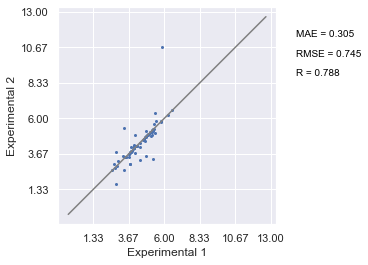

In [39]:
plot_diagram(chembl,['Smiles_unify'],'value_nM_log')

### be ready for concat

In [40]:
chembl['source'] = 'ChEMBL'
chembl['property'] = 'solubility'

In [41]:
chembl_fc = chembl[['Smiles', 'Standard Value', 'Standard Units', 
                    'Document ChEMBL ID', 'source', 
                    'Temperature Range', 'pH', 
                    'property'
                   ]]

In [42]:
chembl_fc.columns = ['Smiles', 'value', 'unit', 
                    'ref', 'source', 
                    'Temperature', 'pH', 
                    'property']

In [43]:
chembl_fc.head(3)

,Smiles,value,unit,ref,source,Temperature,pH,property
13,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,5100.0,ug.mL-1,CHEMBL1138134,ChEMBL,other,7.4,solubility
54,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,26.0,ug.mL-1,CHEMBL1151763,ChEMBL,other,7.4,solubility
86,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,3.0,ug.mL-1,CHEMBL1944507,ChEMBL,other,7.0,solubility


In [44]:
chembl_fc.drop_duplicates(inplace=True)
chembl_fc.shape

(2375, 8)

## ESOL

In [45]:
esol = pd.read_csv('../data/raw_data/solubility/delaney 2004.txt')

In [46]:
esol.shape

(1144, 4)

In [47]:
esol.head(3)

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl


### be ready for concat

In [48]:
esol['Temperature'] =25
esol['Unit'] ='log(mol/L)'
esol['source'] = 'ESOL'
esol['property'] = 'solubility'

In [49]:
esol_fc = esol[['SMILES', 'measured log(solubility:mol/L)', 'Unit', 
               'source', 'Temperature', 'property']]

In [50]:
esol_fc.columns = ['Smiles', 'value', 'unit', 
                    'source', 'Temperature', 'property']

In [51]:
esol_fc.drop_duplicates(inplace=True)
esol_fc.shape

(1140, 6)

## Cuietal

In [52]:
cuietal = pd.read_excel('../data/raw_data/solubility/9,943 compounds_0.xlsx')

In [53]:
cuietal.shape

(9943, 6)

In [54]:
cuietal.head(3)

,Compound ID,InChIKey,SMILES,logS,logP,MW
0,C1711,ACTIUHUUMQJHFO-UPTCCGCDSA-N,COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...,-18.217693,17.8539,863.344
1,C1712,CQISYTXUORWJSX-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...,-17.468457,14.2326,641.065
2,C1713,UXPYIAWFQKSHNV-UHFFFAOYSA-N,CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC,-16.259392,11.8156,566.939


### be ready for concat

In [55]:
cuietal['Temperature'] =25
cuietal['Unit'] ='log(mol/L)'
cuietal['source'] = 'Cuietal'
cuietal['property'] = 'solubility'

In [56]:
cuietal_fc = cuietal[['SMILES', 'logS', 'Unit', 
               'source', 'Temperature', 'property']]

In [57]:
cuietal_fc.columns = ['Smiles', 'value', 'unit', 
                    'source', 'Temperature', 'property']

In [58]:
cuietal_fc.drop_duplicates(inplace=True)
cuietal_fc.shape

(9943, 6)

## ONSchallenge

In [59]:
ons = pd.read_csv('../data/raw_data/solubility/water_solubility_data.csv')

In [60]:
ons.shape

(900, 10)

In [61]:
ons.head(3)

,StdInChIKey,Smiles,LogS,T,Source,REF1,REF2,REF3,REF4,REF5
0,AAEVYOVXGOFMJO-UHFFFAOYSA-N,S(C)c1nc(NC(C)C)nc(NC(C)C)n1,-4.10,NaN,ONSchallenge,http://dx.doi.org/10.1021/ci800406y,NaN,NaN,NaN,NaN
1,ABICJYZKIYUWEE-UHFFFAOYSA-N,O=[N+]([O-])C1C(=O)NC(=O)NC1=O,-2.28,NaN,ONSchallenge,http://dx.doi.org/10.1021/ci800406y,NaN,NaN,NaN,NaN
2,ADIMAYPTOBDMTL-UHFFFAOYSA-N,Clc1cc2C(=NC(O)C(=O)Nc2cc1)c1ccccc1,-3.95,NaN,ONSchallenge,http://dx.doi.org/10.1021/ci800406y,NaN,NaN,NaN,NaN


### be ready for concat

In [62]:
ons['Temperature'] = np.nan
ons['Unit'] ='log(mol/L)'
ons['property'] = 'solubility'

In [63]:
ons_fc = ons[['Smiles', 'LogS', 'Unit', 'REF1', 
               'Source', 'Temperature', 'property']]

In [64]:
ons_fc.columns = ['Smiles', 'value', 'unit', 'ref', 
                    'source', 'Temperature', 'property']

In [65]:
ons_fc.drop_duplicates(inplace=True)
ons_fc.shape

(900, 7)

## Wangetal

In [66]:
wangetal1 = pd.read_excel('../data/raw_data/solubility/Wangetal/ci800406y_si_001.xlsx')
wangetal2 = pd.read_excel('../data/raw_data/solubility/Wangetal/Jain and Yalkowsky.xls')
wangetal3 = pd.read_excel('../data/raw_data/solubility/Wangetal/Beilstein.xlsx')
wangetal4 = pd.read_excel('../data/raw_data/solubility/Wangetal/goodman_25celsius.xlsx')
wangetal5 = pd.read_excel('../data/raw_data/solubility/Wangetal/wang_collected.xlsx')

In [67]:
wangetal1.shape, wangetal2.shape, wangetal3.shape, wangetal4.shape, wangetal5.shape 

((1708, 6), (578, 7), (1210, 6), (90, 6), (119, 7))

In [68]:
wangetal3.drop(columns=['Entry'], inplace=True)

In [69]:
wangetal1['ref'] = 'https://pubs.acs.org/doi/10.1021/ci700096r'
wangetal2['ref'] = 'https://jpharmsci.org/article/S0022-3549(16)30715-8/fulltext'
wangetal3['ref'] = 'Beilstein data set'
wangetal4['ref'] = 'Goodman’s data set'
wangetal5['ref'] = 'Wang et al. collected'

In [70]:
wangetal = pd.concat([wangetal1, wangetal2, wangetal3, wangetal4, wangetal5], ignore_index=True)
wangetal.shape

(3705, 9)

In [71]:
wangetal.head(3)

,No,Expt.,ClogP,Polarizability,Name,SLN,ref,Tm,MP
0,1,-4.35,4.22,133.981,1-bromonapthtalene,BrC[2]C[3]=C(CH=CHCH=@2)CH=CHCH=CH@3,https://pubs.acs.org/doi/10.1021/ci700096r,NaN,NaN
1,2,-3.33,2.95,130.274,bromoxynil,BrC[2]=C(C(=CHC(=CH@2)C#N)Br)OH,https://pubs.acs.org/doi/10.1021/ci700096r,NaN,NaN
2,3,-6.98,5.00,154.335,"1,2,4,5-tetrabromobenzene",BrC[2]=C(CH=C(C(=CH@2)Br)Br)Br,https://pubs.acs.org/doi/10.1021/ci700096r,NaN,NaN


In [72]:
wangetal['Temperature'] = np.nan
wangetal.loc[wangetal['ref'] == 'https://pubs.acs.org/doi/10.1021/ci700096r', 'Temperature'] = 25
wangetal.loc[wangetal['ref'] == 'Goodman’s data set', 'Temperature'] = 25

In [73]:
from rdkit.Chem import rdSLNParse
wangetal['mol'] = wangetal['SLN'].apply(lambda x: Chem.rdSLNParse.MolFromSLN(x))
wangetal['Smiles'] = wangetal['mol'].apply(lambda x: Chem.MolToSmiles(x))

### be ready for concat

In [74]:
wangetal['Unit'] ='log(mol/L)'
wangetal['source'] = 'Wangetal'
wangetal['property'] = 'solubility'

In [75]:
wangetal_fc = wangetal[['Smiles', 'Expt.', 'Unit', 'ref', 
               'source', 'Temperature', 'property']]

In [76]:
wangetal_fc.columns = ['Smiles', 'value', 'unit', 'ref', 
                    'source', 'Temperature', 'property']

In [77]:
wangetal_fc.drop_duplicates(inplace=True)
wangetal_fc.shape

(3671, 7)

# Concat all data

In [78]:
df = pd.concat([chembl_fc, esol_fc, cuietal_fc, ons_fc, wangetal_fc], ignore_index=True)
df.shape

(18029, 8)

In [79]:
df['ref'].nunique()

318

In [80]:
df

,Smiles,value,unit,ref,source,Temperature,pH,property
0,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,5100.0000,ug.mL-1,CHEMBL1138134,ChEMBL,other,7.4,solubility
1,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,26.0000,ug.mL-1,CHEMBL1151763,ChEMBL,other,7.4,solubility
2,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,3.0000,ug.mL-1,CHEMBL1944507,ChEMBL,other,7.0,solubility
3,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CN4CCCC4)c...,20.0000,ug.mL-1,CHEMBL1142456,ChEMBL,other,7.4,solubility
4,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CCO)ccc23)...,1.0000,ug.mL-1,CHEMBL1142456,ChEMBL,other,7.4,solubility
...,...,...,...,...,...,...,...,...
18024,NS(=O)(=O)c1ccc(C(=O)c2ccc(CNCc3ccccc3)cc2)s1,-3.3319,log(mol/L),Wang et al. collected,Wangetal,NaN,NaN,solubility
18025,CCCCNCc1ccc(C(=O)c2ccc(S(N)(=O)=O)s2)cc1,-2.1669,log(mol/L),Wang et al. collected,Wangetal,NaN,NaN,solubility
18026,NS(=O)(=O)c1ccc(C(=O)c2ccc(CN3CCOCC3)cc2)s1,-1.4812,log(mol/L),Wang et al. collected,Wangetal,NaN,NaN,solubility
18027,CN1CCN(Cc2ccc(C(=O)c3ccc(S(N)(=O)=O)s3)cc2)CC1,-1.8802,log(mol/L),Wang et al. collected,Wangetal,NaN,NaN,solubility


In [81]:
df.head(3)

,Smiles,value,unit,ref,source,Temperature,pH,property
0,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,5100.0,ug.mL-1,CHEMBL1138134,ChEMBL,other,7.4,solubility
1,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,26.0,ug.mL-1,CHEMBL1151763,ChEMBL,other,7.4,solubility
2,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,3.0,ug.mL-1,CHEMBL1944507,ChEMBL,other,7.0,solubility


In [82]:
df = process_stage_1(df,'Smiles')

100%|██████████████████████████████████████| 18029/18029 [00:00<00:00, 18934.71it/s]


SANITIZE_NONE    18029
Name: Smiles_check, dtype: int64


100%|█████████████████████████████████████| 18029/18029 [00:00<00:00, 965909.29it/s]
18029it [00:17, 1029.93it/s]


Metal in Smiles amount: 50


100%|██████████████████████████████████████| 17979/17979 [00:01<00:00, 16247.59it/s]


# Value unify

In [83]:
df['unit'].value_counts(dropna=False)

log(mol/L)    15604
ug.mL-1        1226
nM             1149
Name: unit, dtype: int64

In [84]:
df['MW'] = df['Smiles_unify'].apply(lambda x: Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))

In [85]:
def standardlised_value(x):
    value = float(x['value'])
    unit = x['unit']
    mw = x['MW']
    
    if unit == 'nM':
        return value
    elif unit == 'ug.mL-1':
        return value/mw*1000000
    elif unit == 'log(mol/L)':
        return 10**value*1000000000
    else:
        print(unit)

In [86]:
df['value_nM'] = df.apply(standardlised_value,axis=1)

# Filter values

In [87]:
df = df[df['value_nM'] != 0]
df.shape

(17979, 13)

In [88]:
df['value_nM_log'] = df['value_nM'].apply(lambda x: round(np.log10(x), 4))

In [89]:
df = AtomCounts(df, 'Smiles_unify', 10)

alldata shape: (17979, 15)
AtomCounts shape: (14828, 15)


In [90]:
df = df[['Smiles_unify', 'Smiles', 'value_nM', 'value_nM_log', 
        'ref', 'source', 'Temperature', 'pH', 'property']]
df.shape

(14818, 9)

In [92]:
df.to_csv('../data/data_processing_result/solubility_preprocessing_finished.csv',index=False)

In [93]:
df

,Smiles_unify,Smiles,value_nM,value_nM_log,ref,source,Temperature,pH,property
0,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,1.341523e+07,7.1276,CHEMBL1138134,ChEMBL,other,7.4,solubility
1,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,6.339401e+04,4.8020,CHEMBL1151763,ChEMBL,other,7.4,solubility
2,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,6.477938e+03,3.8114,CHEMBL1944507,ChEMBL,other,7.0,solubility
3,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CN4CCCC4)c...,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CN4CCCC4)c...,3.998760e+04,4.6019,CHEMBL1142456,ChEMBL,other,7.4,solubility
4,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CCO)ccc23)...,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CCO)ccc23)...,2.168691e+03,3.3362,CHEMBL1142456,ChEMBL,other,7.4,solubility
...,...,...,...,...,...,...,...,...,...
18024,NS(=O)(=O)c1ccc(C(=O)c2ccc(CNCc3ccccc3)cc2)s1,NS(=O)(=O)c1ccc(C(=O)c2ccc(CNCc3ccccc3)cc2)s1,4.656933e+05,5.6681,Wang et al. collected,Wangetal,NaN,NaN,solubility
18025,CCCCNCc1ccc(C(=O)c2ccc(S(N)(=O)=O)s2)cc1,CCCCNCc1ccc(C(=O)c2ccc(S(N)(=O)=O)s2)cc1,6.809261e+06,6.8331,Wang et al. collected,Wangetal,NaN,NaN,solubility
18026,NS(=O)(=O)c1ccc(C(=O)c2ccc(CN3CCOCC3)cc2)s1,NS(=O)(=O)c1ccc(C(=O)c2ccc(CN3CCOCC3)cc2)s1,3.302174e+07,7.5188,Wang et al. collected,Wangetal,NaN,NaN,solubility
18027,CN1CCN(Cc2ccc(C(=O)c3ccc(S(N)(=O)=O)s3)cc2)CC1,CN1CCN(Cc2ccc(C(=O)c3ccc(S(N)(=O)=O)s3)cc2)CC1,1.317650e+07,7.1198,Wang et al. collected,Wangetal,NaN,NaN,solubility
